In [1]:
import sys
# Clear all imports from previous runs
sys.modules.pop('dataset', None)
sys.modules.pop('model', None)

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
torch.set_default_tensor_type('torch.DoubleTensor')
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
from dataset import TrajectoryDataset
from model import Phi_Net, H_Net_CrossEntropy, Model, save_model, load_model


/Users/yefan/opt/miniconda3/envs/cds245/lib/python3.10/site-packages/torch/__init__.py:1236: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:436.)
  _C._set_default_tensor_type(t)


In [2]:
data_dir = Path('/Users/yefan/Desktop/CDS245/simple-quad-sim/data')
amplitudes = [0, 0.5, 1, 1.5, 2]
datasets = [TrajectoryDataset(data_dir, c) for c in amplitudes]


  0%|          | 0/125 [00:00<?, ?it/s]/Users/yefan/Desktop/CDS245/simple-quad-sim/dataset.py:48: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.data = pd.concat([self.data, pd.DataFrame({
100%|██████████| 125/125 [00:00<00:00, 265.04it/s]


X.shape: (500000, 11) Y.shape: (500000, 3) c.shape: (500000,)


  0%|          | 0/125 [00:00<?, ?it/s]/Users/yefan/Desktop/CDS245/simple-quad-sim/dataset.py:48: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.data = pd.concat([self.data, pd.DataFrame({
100%|██████████| 125/125 [00:00<00:00, 1993.62it/s]


X.shape: (500000, 11) Y.shape: (500000, 3) c.shape: (500000,)


  0%|          | 0/125 [00:00<?, ?it/s]/Users/yefan/Desktop/CDS245/simple-quad-sim/dataset.py:48: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.data = pd.concat([self.data, pd.DataFrame({
100%|██████████| 125/125 [00:00<00:00, 1834.65it/s]


X.shape: (500000, 11) Y.shape: (500000, 3) c.shape: (500000,)


  0%|          | 0/125 [00:00<?, ?it/s]/Users/yefan/Desktop/CDS245/simple-quad-sim/dataset.py:48: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.data = pd.concat([self.data, pd.DataFrame({
100%|██████████| 125/125 [00:00<00:00, 1782.18it/s]


X.shape: (500000, 11) Y.shape: (500000, 3) c.shape: (500000,)


  0%|          | 0/125 [00:00<?, ?it/s]/Users/yefan/Desktop/CDS245/simple-quad-sim/dataset.py:48: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.data = pd.concat([self.data, pd.DataFrame({
100%|██████████| 125/125 [00:00<00:00, 1966.21it/s]


X.shape: (500000, 11) Y.shape: (500000, 3) c.shape: (500000,)


In [3]:
omegas = [0, 0.5, 1, 1.5, 2]
options = {}
dim_x = 4 + 4 + 3
dim_y = 3
num_c = len(amplitudes)
dim_a = 3
learning_rate = 5e-4

print('dims of (x, y) are', (dim_x, dim_y))
print('there are ' + str(num_c) + ' different conditions')

dims of (x, y) are (11, 3)
there are 5 different conditions


In [4]:

Trainloader = []
Adaptloader = []
for i in range(len(amplitudes)):
    fullset = datasets[i]

    l = len(fullset)
    trainset, adaptset = random_split(fullset, [int(l*2/3), l-int(l*2/3)])

    trainloader = DataLoader(trainset, batch_size=256, shuffle=True)
    adaptloader = DataLoader(adaptset, batch_size=32, shuffle=True)

    Trainloader.append(trainloader)
    Adaptloader.append(adaptloader)


## Initialize the models

In [5]:
phi_net = Phi_Net(dim_x, dim_a)
h_net = H_Net_CrossEntropy(dim_a, num_c)
criterion = nn.MSELoss()
criterion_h = nn.CrossEntropyLoss()
optimizer_h = optim.Adam(h_net.parameters(), lr=learning_rate)
optimizer_phi = optim.Adam(phi_net.parameters(), lr=learning_rate)

In [6]:
model_save_freq = 50

Loss_f = [] # combined force prediction loss
Loss_c = [] # combined adversarial loss

alpha = 0.01
SN = 2

for epoch in range(1000):
    arr = np.arange(len(amplitudes))
    np.random.shuffle(arr)

    # Running loss over all subdatasets
    running_loss_f = 0.0
    running_loss_c = 0.0

    for i in arr:
        with torch.no_grad():
            adaptloader = Adaptloader[i]
            kshot_data = next(iter(adaptloader))
            trainloader = Trainloader[i]
            data = next(iter(trainloader))
        
        optimizer_phi.zero_grad()

        '''
        Least-square to get $a$ from K-shot data
        '''
        X = kshot_data[0]
        Y = kshot_data[1]
        phi = phi_net(X)
        phi_T = phi.transpose(0, 1)
        A = torch.inverse(torch.mm(phi_T, phi))
        a = torch.mm(torch.mm(A, phi_T), Y)

        if torch.norm(a, 'fro') > 10:
            a = a / torch.norm(a, 'fro') * 10
        
        '''
        Batch training \phi_net
        '''
        inputs = data[0]
        labels = data[1]

        c_labels = data[2].type(torch.long)

        # forward + backward + optimize
        outputs = torch.mm(phi_net(inputs), a)
        loss_f = criterion(outputs, labels)
        temp = phi_net(inputs)

        loss_c = criterion_h(h_net(temp), c_labels)

        loss_phi = loss_f - alpha * loss_c
        loss_phi.backward()
        optimizer_phi.step()

        '''
        Discriminator training
        '''
        if np.random.rand() <= 1.0 / 2:
            optimizer_h.zero_grad()
            temp = phi_net(inputs)
            
            loss_c = criterion_h(h_net(temp), c_labels)
            
            loss_h = loss_c
            loss_h.backward()
            optimizer_h.step()
        
        '''
        Spectral normalization
        '''
        if SN > 0:
            for param in phi_net.parameters():
                M = param.detach().numpy()
                if M.ndim > 1:
                    s = np.linalg.norm(M, 2)
                    if s > SN:
                        param.data = param / s * SN
        
        running_loss_f += loss_f.item()
        running_loss_c += loss_c.item()
    
    # Save statistics
    Loss_f.append(running_loss_f / len(amplitudes))
    Loss_c.append(running_loss_c / len(amplitudes))
    if epoch % 10 == 0:
        print('[%d] loss_f: %.2f loss_c: %.2f' % (epoch + 1, running_loss_f / len(amplitudes), running_loss_c / len(amplitudes)))

    if epoch % model_save_freq == 0:
        save_model(phi_net=phi_net, h_net=h_net, modelname=f'epoch{epoch}')

[1] loss_f: 8.75 loss_c: 1.51
[11] loss_f: 4.79 loss_c: 1.44
[21] loss_f: 3.47 loss_c: 1.40
[31] loss_f: 5.53 loss_c: 1.38
[41] loss_f: 3.03 loss_c: 1.30
[51] loss_f: 3.65 loss_c: 1.27
[61] loss_f: 2.60 loss_c: 1.26
[71] loss_f: 5.58 loss_c: 1.26
[81] loss_f: 2.94 loss_c: 1.28
[91] loss_f: 3.99 loss_c: 1.23
[101] loss_f: 1.74 loss_c: 1.20
[111] loss_f: 3.55 loss_c: 1.18
[121] loss_f: 2.24 loss_c: 1.15
[131] loss_f: 4.34 loss_c: 1.15
[141] loss_f: 3.01 loss_c: 1.13
[151] loss_f: 3.59 loss_c: 1.11
[161] loss_f: 4.79 loss_c: 1.12
[171] loss_f: 6.48 loss_c: 1.11
[181] loss_f: 4.57 loss_c: 1.12
[191] loss_f: 1.68 loss_c: 1.10
[201] loss_f: 4.93 loss_c: 1.08
[211] loss_f: 3.13 loss_c: 1.09
[221] loss_f: 3.07 loss_c: 1.09
[231] loss_f: 2.17 loss_c: 1.08
[241] loss_f: 2.37 loss_c: 1.08
[251] loss_f: 3.65 loss_c: 1.09
[261] loss_f: 5.56 loss_c: 1.09
[271] loss_f: 1.43 loss_c: 1.10
[281] loss_f: 5.89 loss_c: 1.09
[291] loss_f: 4.68 loss_c: 1.08
[301] loss_f: 5.17 loss_c: 1.08
[311] loss_f: 1.79 

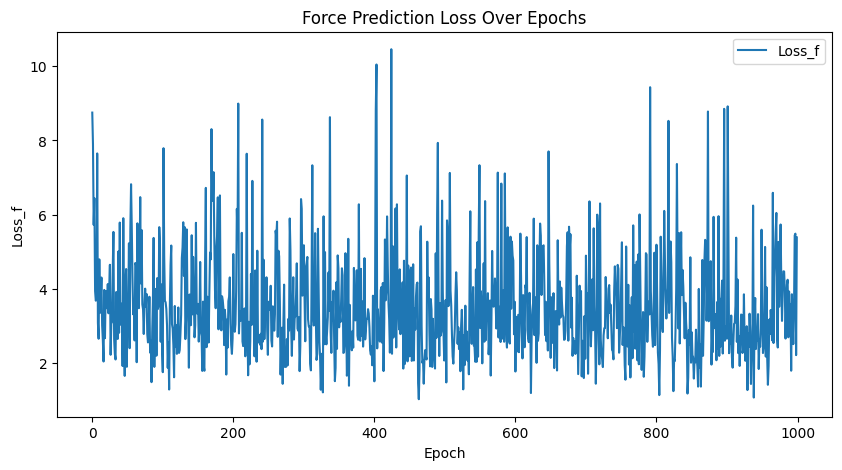

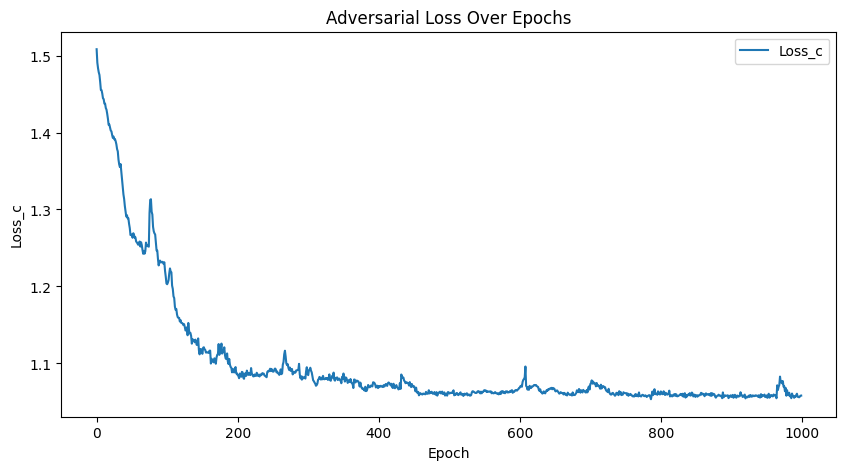

In [7]:
# Plot loss_f
plt.figure(figsize=(10, 5))
plt.plot(Loss_f, label='Loss_f')
plt.xlabel('Epoch')
plt.ylabel('Loss_f')
plt.title('Force Prediction Loss Over Epochs')
plt.legend()
plt.show()

# Plot loss_c
plt.figure(figsize=(10, 5))
plt.plot(Loss_c, label='Loss_c')
plt.xlabel('Epoch')
plt.ylabel('Loss_c')
plt.title('Adversarial Loss Over Epochs')
plt.legend()
plt.show()